In [92]:
import numpy as np
np.random.seed(12)
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import os
from scipy.optimize import curve_fit
import pandas as pd

%matplotlib inline

In [93]:
DATA_DIR = '~/Desktop/FTS/cryo_fts_data/scan_data/taurus_band_tests/'
DATA_FILE = '20260204_153620.csv'
data = pd.read_csv(os.path.join(DATA_DIR, DATA_FILE), comment = '#')
data = data.drop(index=0)
data

,timestamp,position_mm,x,y,r,theta
1,1.770241e+09,0.252686,-4.277393e-06,6.159630e-06,0.000007,124.777016
2,1.770241e+09,0.544678,1.112247e-06,-6.329848e-06,0.000006,-80.034019
3,1.770241e+09,0.848145,-4.734208e-06,-6.705623e-06,0.000008,-125.222298
4,1.770241e+09,1.154785,-2.925282e-07,6.981336e-06,0.000007,92.399368
5,1.770241e+09,1.455322,-3.683183e-06,7.444755e-06,0.000008,116.323212
...,...,...,...,...,...,...
649,1.770241e+09,197.641602,5.269714e-06,-2.226886e-06,0.000006,-22.908039
650,1.770241e+09,197.951660,-2.781004e-06,-2.641175e-07,0.000003,-174.574753
651,1.770241e+09,198.259521,-6.287964e-06,-1.733343e-06,0.000007,-164.588562
652,1.770241e+09,198.565918,-3.194817e-06,-8.892339e-06,0.000009,-109.762207


In [94]:
TIMESTAMPS = data['timestamp'].values * u.s
POS = data['position_mm'].values * u.mm
R = data['r'].values * u.V  # Assuming lock-in outputs in V
X = data['x'].values * u.V
Y = data['y'].values * u.V
THETA = data['theta'].values * u.deg

print(f"Total samples: {len(POS)}")
print(f"Position range: {POS.min():.2f} to {POS.max():.2f}")
print(f"Scan duration: {(TIMESTAMPS[-1] - TIMESTAMPS[0]):.2f}")

Total samples: 653
Position range: 0.25 mm to 198.87 mm
Scan duration: 66.22 s


In [95]:
OPD = POS * 2
I = (R - np.mean(R)).to(u.mV)

In [96]:
OPD_INTERP = np.linspace(OPD.min(), OPD.max(), OPD.size)
I_INTERP = np.interp(OPD_INTERP, OPD, I)

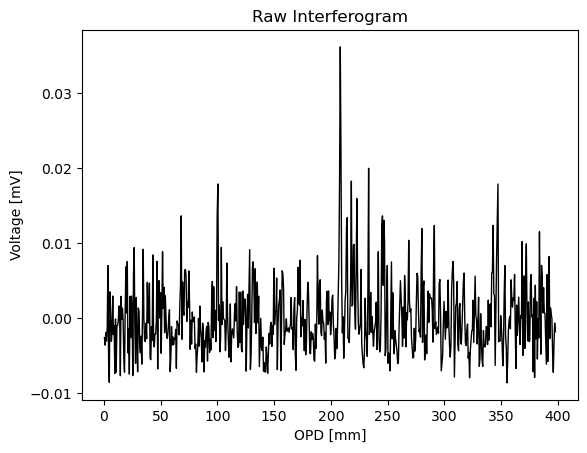

In [97]:
plt.plot(OPD_INTERP, I_INTERP, 'k', lw=1)
plt.title('Raw Interferogram')
plt.ylabel(f'Voltage [{I.unit}]')
plt.xlabel(f'OPD [{OPD.unit}]')
plt.show()

In [98]:
SPECTRUM = np.fft.rfft(I_INTERP)
POWER = np.abs(SPECTRUM)**2

WAVENUMBERS = np.fft.rfftfreq(OPD_INTERP.size, np.diff(OPD_INTERP).mean()).to(1/u.cm)
FREQS = WAVENUMBERS.to(u.GHz, equivalencies=u.spectral())

nyq_freq = (const.c / (2 * np.diff(OPD_INTERP).mean())).to(u.GHz)
print(f"Nyquist frequency: {nyq_freq:.1f}")

Nyquist frequency: 246.0 GHz


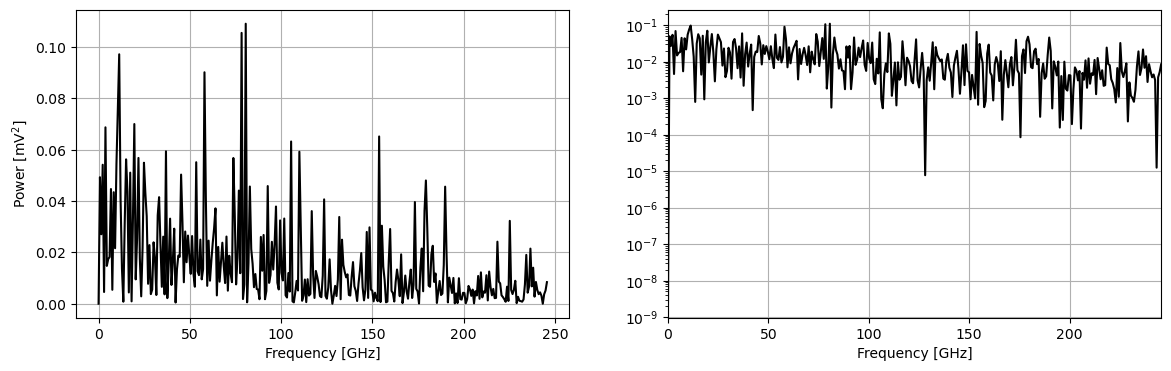

In [99]:
POWER_UNIT = r'$\mathrm{mV^2}$'

%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(FREQS, POWER, color='k', lw=1.5)
axes[0].set_xlabel(rf'Frequency [{FREQS.unit}]')
axes[0].set_ylabel(rf'Power [{POWER_UNIT}]')
#axes[0].set_xlim(60, 100)
axes[0].grid()

axes[1].semilogy(FREQS, POWER, color='k', lw=1.5)
axes[1].set_xlabel(rf'Frequency [{FREQS.unit}]')
axes[1].set_xlim(0, FREQS.value.max())
axes[1].grid()
plt.show()
